# Classification of B-ALL vs Healthy blood cells using ResNet50 pre-trained on ImageNet.

## Steps include:

1. Importing dataset from Kaggle
2. Reading the train and test sets
3. Converting the data into tensors
4. Pre-processing pipeline
5. Data Augmentation
6. Model definition
7. Defining callbacks - Learning Rate scheduler, Early Stopping
8. Class weights for cost-sensitive learning
9. Model training using Stratified K-fold cross-validation
10. Model evaluation on the test set

## Import Dataset from Kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parveezrahman","key":"b45e47e3fbd44fa0e7efcf6d7e45e64d"}'}

In [ ]:
def load_kaggledataset():
  ! mkdir ~/.kaggle #create a kaggle directory
  ! cp kaggle.json ~/.kaggle/   #copy the kaggle.json file to folder created
  ! chmod 600 ~/.kaggle/kaggle.json  #permission for the json to act
  !kaggle datasets download -d andrewmvd/leukemia-classification #Load the Leukemia Classification dataset in Colab
  !unzip leukemia-classification.zip #Unzip the files

load_kaggledataset()

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") 

## Import Libraries

In [3]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import random, os, warnings  
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras import optimizers, applications, Sequential, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# GPU
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-fe8bd579-8096-0e47-21d8-f30f00eebae9)


## Set Seeds


In [5]:
seed = 101

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
warnings.filterwarnings('ignore')

In [6]:
BATCH_SIZE = 32 
LEARNING_RATE = 0.0001 
EPOCHS = 40
HEIGHT = 300
WIDTH = 300
ES_PATIENCE = 10
IMAGE_SIZE=[HEIGHT,WIDTH]
OFFSET_HEIGHT = 75
OFFSET_WIDTH = 75
IMAGE_SHAPE = 224

## Reading the Dataset

In [7]:
train_directory = Path('/content/C-NMC_Leukemia/training_data')
test_directory = '/content/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'
test_csv = '/content/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv'

#### Train Set

In [8]:
filepaths = list(train_directory.glob(r'**/*.bmp'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths,name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

train_dir = pd.concat([filepaths,labels], axis=1)
train_dir['Label'].replace(['all','hem'], ['1','0'],inplace=True)

FILENAMES = train_dir['Filepath']
LABELS = train_dir['Label'].astype(np.int64)

In [9]:
train_dir.head(5)

Filepath Label
0  /content/C-NMC_Leukemia/training_data/fold_2/a...     1
1  /content/C-NMC_Leukemia/training_data/fold_2/a...     1
2  /content/C-NMC_Leukemia/training_data/fold_2/a...     1
3  /content/C-NMC_Leukemia/training_data/fold_2/a...     1
4  /content/C-NMC_Leukemia/training_data/fold_2/a...     1

In [10]:
len(train_dir)

10661

#### Test Set

In [11]:
test_data = pd.read_csv(test_csv)
test_dir = test_data.assign(Fullpath = test_directory + test_data['new_names']).astype(str)

TFILENAMES = test_dir['Fullpath']
TLABELS = test_dir['labels'].astype(np.int64)

In [12]:
test_dir.head(5)

Patient_ID new_names labels  \
0   UID_57_29_1_all.bmp     1.bmp      1   
1   UID_57_22_2_all.bmp     2.bmp      1   
2   UID_57_31_3_all.bmp     3.bmp      1   
3  UID_H49_35_1_hem.bmp     4.bmp      0   
4   UID_58_6_13_all.bmp     5.bmp      1   

                                            Fullpath  
0  /content/C-NMC_Leukemia/validation_data/C-NMC_...  
1  /content/C-NMC_Leukemia/validation_data/C-NMC_...  
2  /content/C-NMC_Leukemia/validation_data/C-NMC_...  
3  /content/C-NMC_Leukemia/validation_data/C-NMC_...  
4  /content/C-NMC_Leukemia/validation_data/C-NMC_...

## Data Augmentation

In [13]:
# Horizontal Flip
def h_flip(image, label):   
  image = tf.image.random_flip_left_right(image)
  return image, label

# Vertical Flip
def v_flip(image, label):
  image = tf.image.random_flip_up_down(image)
  return image, label

# Rotation in multiples of 90 degrees
def rotation90(image, label):
  multiples_of_90 = random.randint(0, 2)
  image =tf.image.rot90 (image, k=multiples_of_90)
  return image, label

def data_augment(image, label):
  transformations = {'horizontal flip': h_flip, 
                   'vertical flip': v_flip, 
                   'rotation90' : rotation90,
                   } 
  key = random.choice(list(transformations)) #randomly choosing a transformation to call
  image, label = transformations[key](image, label)
  return image, label

## Pre-processing

In [14]:
def preprocess_data(filenames,labels):
    images = tf.io.read_file(filenames)   # Read the images
    images = tf.image.decode_bmp(images, channels=3) # returns Tensors of type uint8
    images = tf.image.crop_to_bounding_box(images, OFFSET_HEIGHT, OFFSET_WIDTH, HEIGHT, WIDTH) # Center-crop the images
    images = tf.cast(images, tf.float32)/255.0   #Re-scale the images with pixel values between 0 and 1.
    images = tf.image.resize(images, [IMAGE_SHAPE,IMAGE_SHAPE])  # Re-size the images to 224x224
    return images, labels

In [15]:
def fetch_dataset(filenames, labels, augment=False, ordered=False, repeated=False):
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
  if repeated:
    dataset = dataset.repeat()
  if not ordered:
    dataset = dataset.shuffle(2048, reshuffle_each_iteration=True)
  if augment:
    dataset = dataset.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return dataset

### Class Weights for Cost-Sensitive Training

In [16]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(LABELS),
                                        y = LABELS                                                    
                                    )
class_weights = dict(zip(np.unique(LABELS), class_weights)),
class_weights = class_weights[0]

## Model Architecture

In [22]:
# Model Architecture 
def model_fn():
  input_image = tf.keras.layers.Input([None, None, 3], name='input_image')

  base_model = tf.keras.applications.ResNet50(input_tensor=input_image, 
                                    include_top=False, 
                                    weights='imagenet', 
                                    pooling='avg')
  
  base_model.trainable = True

  inputs=base_model.input
  x = keras.layers.Dropout(0.2)(base_model.output)
  x = keras.layers.Dense(1) (x)
  outputs = keras.layers.Activation('sigmoid', dtype=tf.float32)(x) 

  model = tf.keras.Model(inputs = inputs, outputs = outputs)

  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'
                  ])
    
  return model, base_model

### Callbacks

In [18]:
def LearningRateScheduler():
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00000000001)
  return reduce_lr

In [19]:
def EarlyStop():
  es = EarlyStopping(monitor='val_loss', 
                   mode='auto', 
                   patience=10, 
                   restore_best_weights=True, 
                   verbose=1)
  return es

## Training

In [23]:
def train_model (train_data, validation_data):
  STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
  tf.keras.backend.clear_session()
  model, base_model = model_fn()
  model_path = f'model_ResNet50_{fold}.h5'
  history = model.fit(x=train_data, 
                        validation_data=validation_data, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        callbacks=[LearningRateScheduler(), EarlyStop()], 
                        epochs=EPOCHS,  
                        verbose=1,
                        class_weight = class_weights).history
  model.save_weights(model_path)
  return history, model, base_model

In [24]:
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
history_list = []
model_list = []
acc = 0

for fold,(train_index, val_index) in enumerate(folds.split(FILENAMES,LABELS)):
  print(f'\nFOLD: {fold+1}')
  print(f'TRAIN: {len(train_index)} VALID: {len(val_index)}')
  X_train, X_val, y_train, y_val = FILENAMES[train_index], FILENAMES[val_index], LABELS[train_index], LABELS[val_index]
  train_data = fetch_dataset(X_train,y_train, augment=True, ordered=False, repeated=True)
  validation_data=fetch_dataset(X_val, y_val, augment=False, ordered=True, repeated=False)
  history, model, base_model = train_model(train_data, validation_data)
  history_list.append(history)
  model_list.append(model)
  print(f"FOLD {fold+1} Accuracy = {np.max(history['val_accuracy']):.3f}")
  acc += np.max(history['val_accuracy'])

print(f"Avg. validation Accuracy = {acc/3.0}")


FOLD: 1
TRAIN: 7107 VALID: 3554
94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/40
222/222 [==============================] - 83s 296ms/step - loss: 0.2559 - accuracy: 0.8946 - val_loss: 2.1492 - val_accuracy: 0.3180 - lr: 1.0000e-04
Epoch 2/40
222/222 [==============================] - 65s 295ms/step - loss: 0.1555 - accuracy: 0.9424 - val_loss: 3.2259 - val_accuracy: 0.3180 - lr: 1.0000e-04
Epoch 3/40
222/222 [==============================] - 65s 295ms/step - loss: 0.1004 - accuracy: 0.9613 - val_loss: 5.2337 - val_accuracy: 0.3180 - lr: 1.0000e-04
Epoch 4/40
222/222 [==============================] - 65s 292ms/step - loss: 0.0882 - accuracy: 0.9645 - val_loss: 7.7041 - val_accuracy: 0.3180 - lr: 1.0000e-04
Epoch 5/40
222/222 [==============================] - 65s 293ms/step - loss: 0.0448 - accuracy: 0.9849 - val_loss: 7.0936 - val_accuracy: 0.3194 - lr: 1.0000e-05
Epoch 6/40
222/222 [==============================] - 61s 275ms/step - loss: 0.0213 - accura

## Evaluation on Test Set

In [25]:
test_dataset = fetch_dataset(TFILENAMES,TLABELS, augment=False, ordered=True, repeated=False)

In [26]:
def model_evaluation(model, test_dataset):
  predictions = np.squeeze(model.predict(test_dataset))
  predictions = (predictions>= 0.5).astype(int)
  cm = confusion_matrix(TLABELS, predictions, labels=[0, 1])
  clr = classification_report(TLABELS, predictions, labels=[0, 1], target_names=["healthy", "all"])
  plt.figure(figsize=(5, 5))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=["healthy", "all"])
  plt.yticks(ticks=[0.5, 1.5], labels=["healthy", "all"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()
  print("Classification Report:\n----------------------\n", clr)

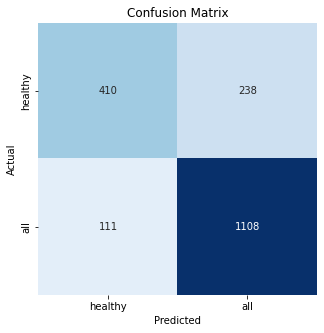

Classification Report:
----------------------
               precision    recall  f1-score   support

     healthy       0.79      0.63      0.70       648
         all       0.82      0.91      0.86      1219

    accuracy                           0.81      1867
   macro avg       0.81      0.77      0.78      1867
weighted avg       0.81      0.81      0.81      1867



In [27]:
model_evaluation(model_list[0], test_dataset)

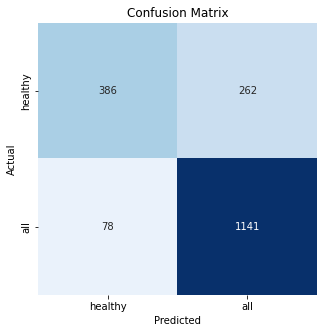

Classification Report:
----------------------
               precision    recall  f1-score   support

     healthy       0.83      0.60      0.69       648
         all       0.81      0.94      0.87      1219

    accuracy                           0.82      1867
   macro avg       0.82      0.77      0.78      1867
weighted avg       0.82      0.82      0.81      1867



In [28]:
model_evaluation(model_list[1], test_dataset)

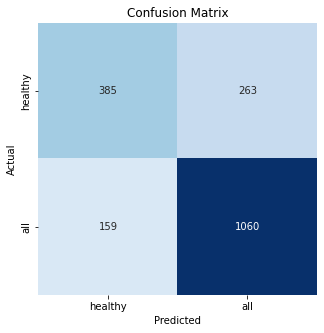

Classification Report:
----------------------
               precision    recall  f1-score   support

     healthy       0.71      0.59      0.65       648
         all       0.80      0.87      0.83      1219

    accuracy                           0.77      1867
   macro avg       0.75      0.73      0.74      1867
weighted avg       0.77      0.77      0.77      1867



In [29]:
model_evaluation(model_list[2], test_dataset)

In [30]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history['loss']
  val_loss = history['val_loss']

  accuracy = history['accuracy']
  val_accuracy = history['val_accuracy']

  epochs = range(len(history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
  plt.rcParams['mathtext.fontset'] = 'custom'
  plt.rcParams['mathtext.it'] = 'Arial:italic'
  plt.rcParams['mathtext.rm'] = 'Arial'

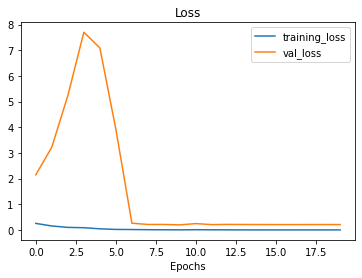

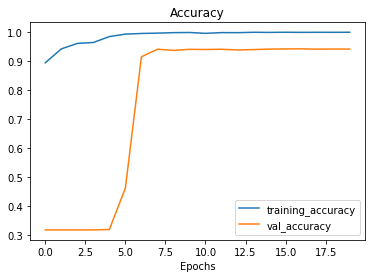

In [31]:
plot_loss_curves(history_list[0])

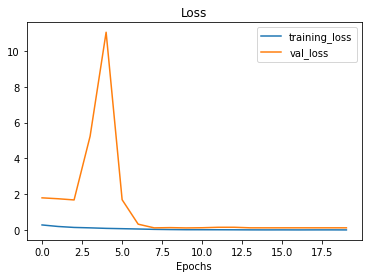

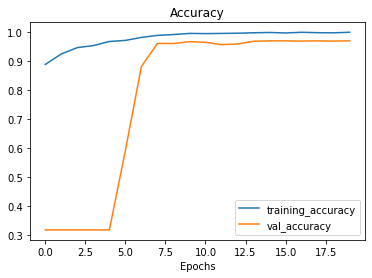

In [32]:
plot_loss_curves(history_list[1])

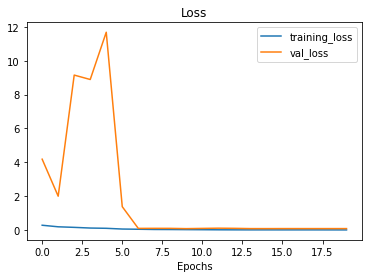

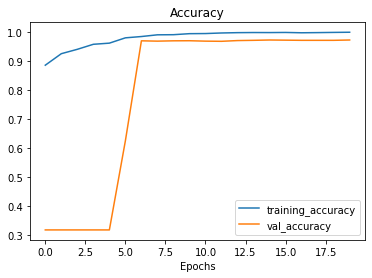

In [33]:
plot_loss_curves(history_list[2])

In [ ]:
# del model
# from keras import backend as K 

# K.clear_session()